In [1]:
## PRELIMINARIES ##
%load_ext autoreload
%autoreload 2

from IPython.display import HTML
from IPython.display import Javascript
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
The raw code for this IPython notebook is by default hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')

In [2]:
# Python imports
import sys
sys.path.append('../')
import glob

In [3]:
# Rankutils imports
from rankutils.cfgloader import *
from rankutils.utilities import safe_create_dir, completedir, getbasename
from rankutils.rIO import read_rank
from rankutils.drawing import colors_from_cmap, rank_plot

In [4]:
# Other imports
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from matplotlib import cm
%matplotlib inline
import mpld3

from sklearn.preprocessing import MinMaxScaler

In [5]:
pathcfg = cfgloader('../path_2.cfg')

In [6]:
expkey = 'places365_001'
k = 10
f = 0.0
z = 1.0
l = 101
m = 10
vs = 3


minmaxscaler = MinMaxScaler((0, 1))

In [7]:
# Loading useful files according to definitions
rkflist = glob.glob(pathcfg.get(expkey, 'rank') + "*.rk")

labelpath = glob.glob("{0:s}*{1:s}*".format(pathcfg.get(expkey, 'label'), pathcfg.get(expkey, 'rktpdir')))[0]
labels = np.load(labelpath)

collmpath = glob.glob("{0:s}*{1:s}*".format(pathcfg.get(expkey, 'collmatches'), pathcfg.get(expkey, 'rktpdir')))[0]
collm = np.load(collmpath)

namelist = np.loadtxt(pathcfg.get(expkey, 'namelist'), usecols=0, dtype='U100')

In [8]:
def iou(a, b):
    
    intersect = np.intersect1d(a, b)
    union = np.union1d(a, b)
    
    return intersect.size/union.size

In [9]:
def maj_vote_labels(labels, k, step):
    
    maj_votes = labels.astype(np.float32).copy()
    
    for i in range(1, step):
        maj_votes[0:k] += maj_votes[0 + i:k + i]
        
    maj_votes = np.round(maj_votes[0:k]/step).astype(np.uint8)
    
    return maj_votes

In [10]:
c = 10
np.random.seed(10)
iidx_list = np.random.choice(np.arange(len(rkflist)), c, replace=False)

## Places365 -- 001

### 10 x 10 Patches

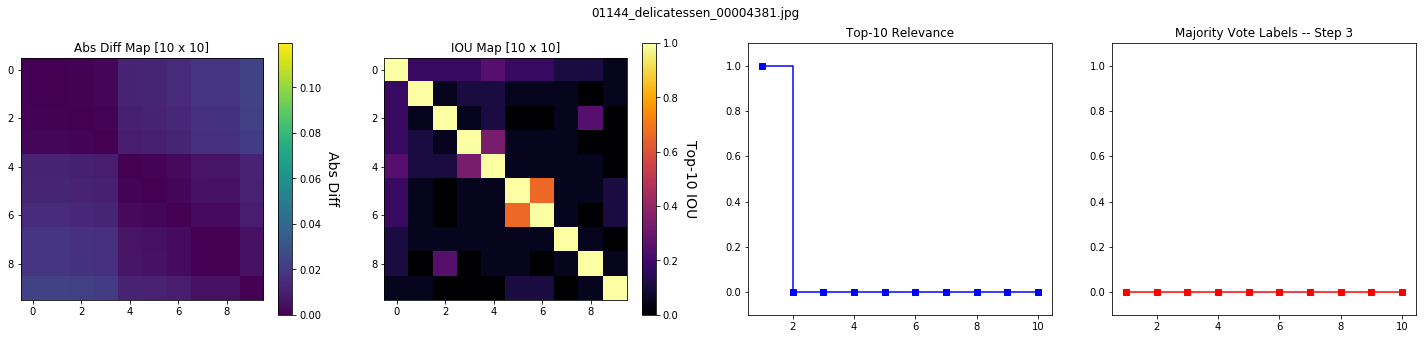

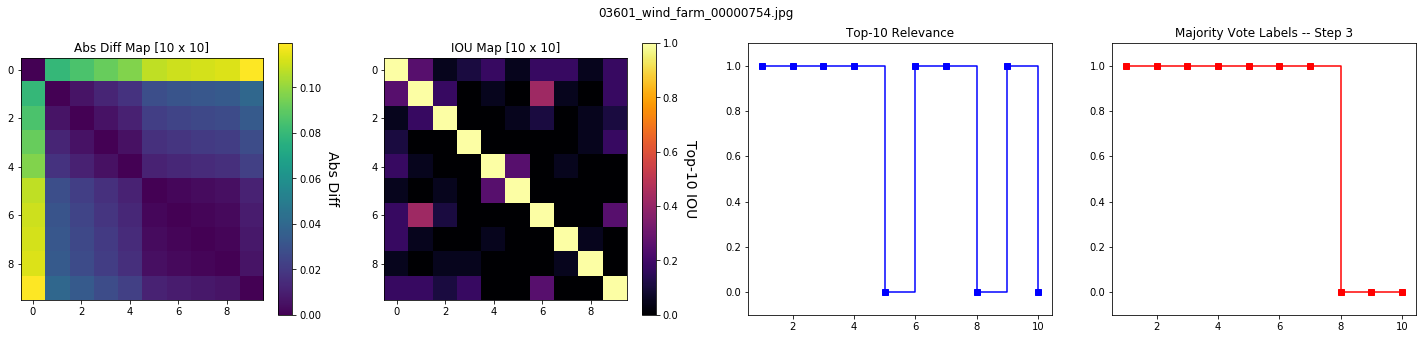

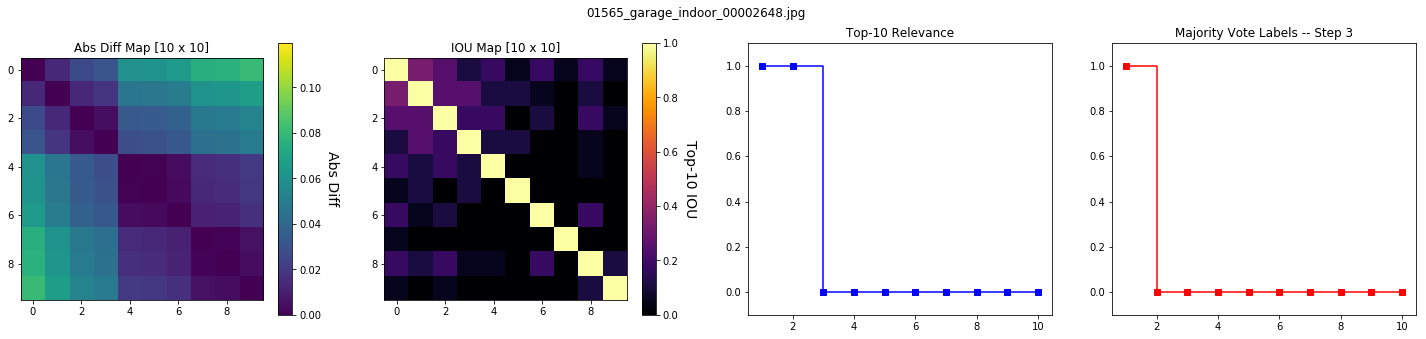

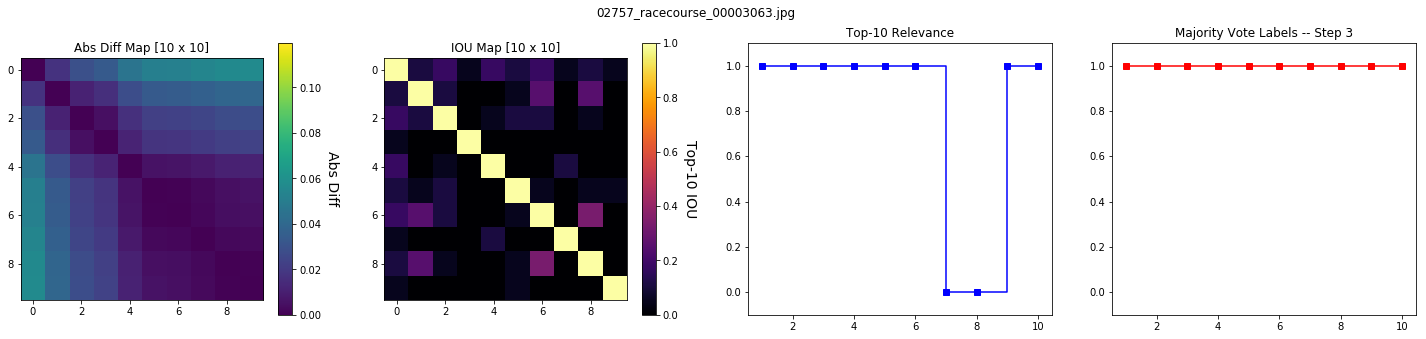

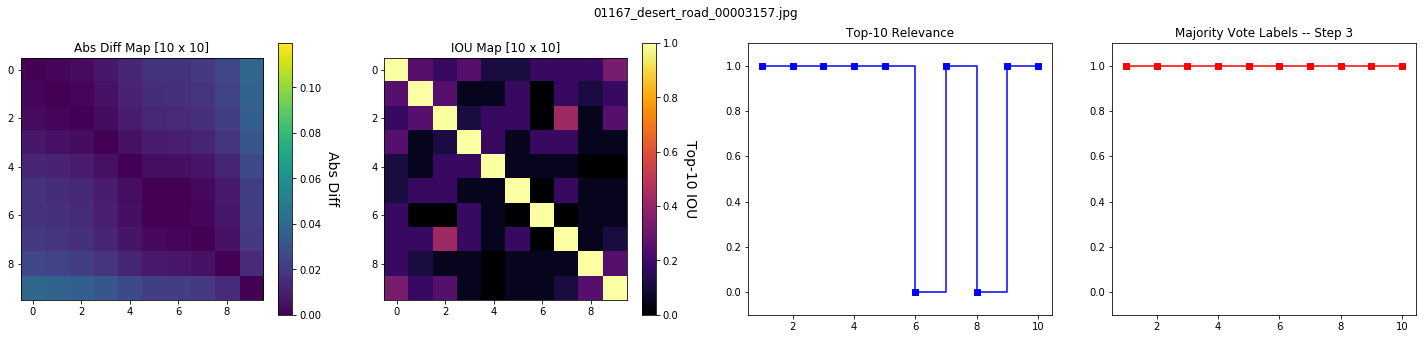

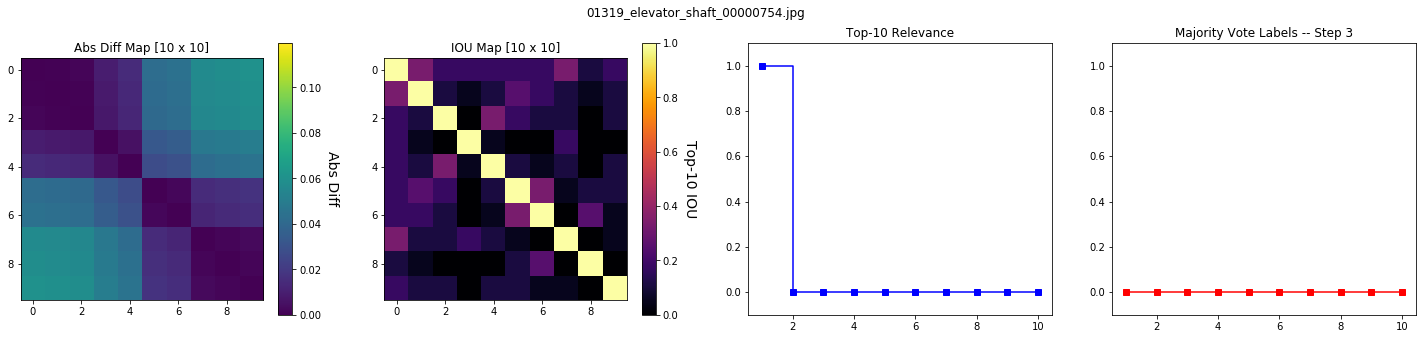

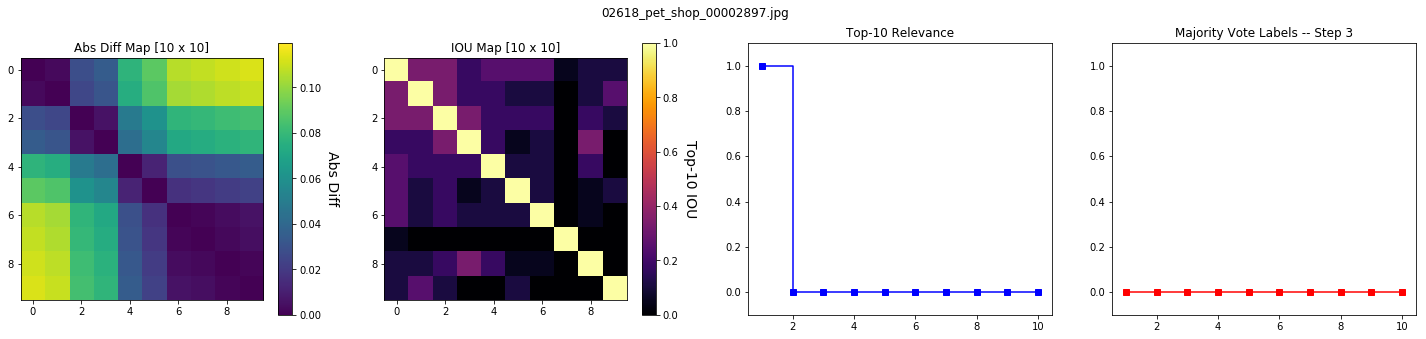

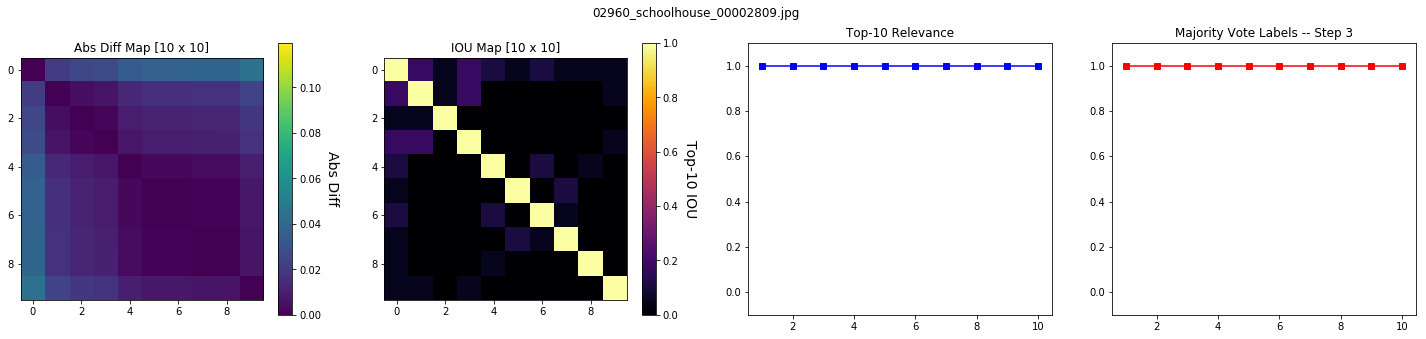

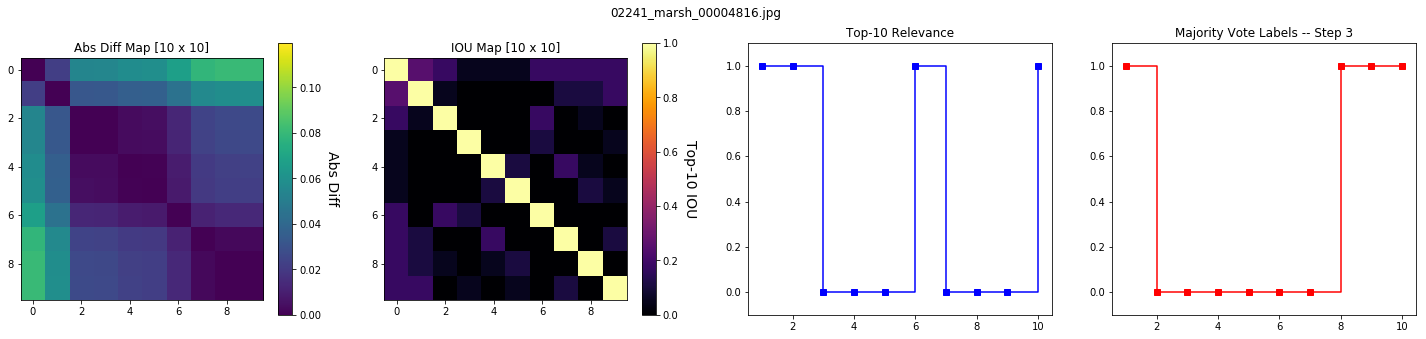

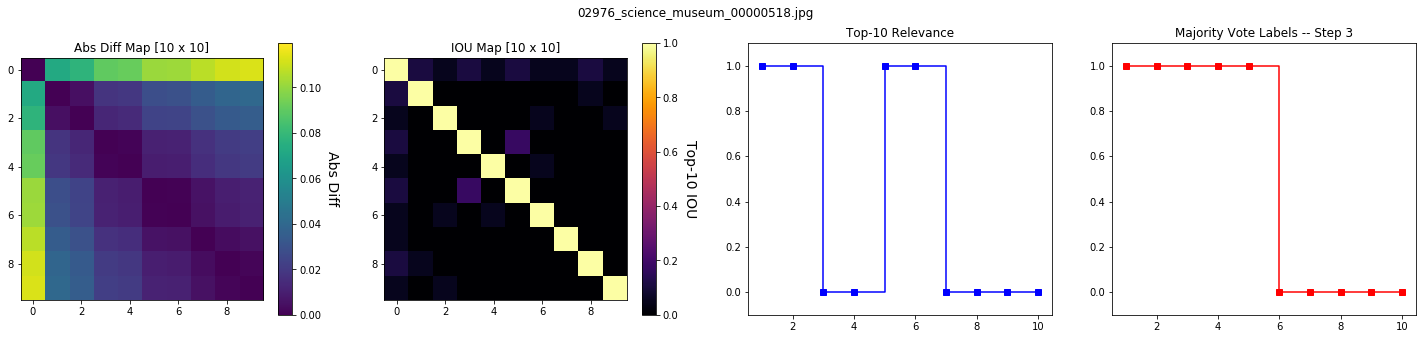

In [11]:
diff_maps = []
iou_maps = []
label_array = []
titles = []

for i in iidx_list:
    rkfpath = rkflist[i]
    titles.append(getbasename(rkfpath))
    rank = read_rank(rkfpath)
    rank_s = minmaxscaler.fit_transform(rank['score'].reshape(-1, 1)).reshape(-1)
    rank_c = 1.0 - rank_s
    
    ###
    diff_maps.append(np.abs(rank_c[1:m+1].reshape(-1, 1) - rank_c[1:m+1].reshape(1, -1)))
    ###
    
    ###
    top_idx = np.searchsorted(namelist, rank['name'][0:m])
    top_idx_array = collm[top_idx, 0:m]

    iou_map = np.zeros((top_idx_array.shape[0], top_idx_array.shape[0]), dtype=np.float64)
    for j, row in enumerate(top_idx_array):
        iou_map[j] = np.apply_along_axis(iou, axis=1, arr=top_idx_array, **dict(b=row))
        
    iou_maps.append(iou_map)
    ###
    
    ###
    label_array.append(labels[i, 0:k+vs])
    
diff_maps = np.stack(diff_maps)
iou_maps = np.stack(iou_maps)
label_array = np.vstack(label_array)

min_diff = np.min(diff_maps)
max_diff = np.max(diff_maps)
    
for i in range(c):
    
    diff_map = diff_maps[i]
    iou_map = iou_maps[i]
    l = label_array[i]
    mv = maj_vote_labels(l, k, vs)
    
    x = np.arange(1, k+1, 1)
    ###
    
    fig, ax = plt.subplots(1, 4)
    fig.set_size_inches(25, 5)

    im = ax[0].imshow(diff_map, plt.get_cmap('viridis'), vmin=min_diff, vmax=max_diff)
    cbar = fig.colorbar(im, ax=ax[0])
    cbar.ax.set_ylabel('Abs Diff', rotation=-90, va="bottom", fontdict=dict(fontsize=14))
    ax[0].set_title('Abs Diff Map [{0:d} x {0:d}]'.format(m))

    im = ax[1].imshow(iou_map, plt.get_cmap('inferno'), vmin=0.0, vmax=1.0)
    cbar = fig.colorbar(im, ax=ax[1])
    cbar.ax.set_ylabel('Top-{0:d} IOU'.format(k), rotation=-90, va="bottom", fontdict=dict(fontsize=14))
    ax[1].set_title('IOU Map [{0:d} x {0:d}]'.format(m))
    
    ax[2].step(x, l[0:k], color='blue', marker='s', where='post', label='post')
    ax[2].set_title('Top-{0:d} Relevance'.format(k))
    ax[2].set_ylim(bottom=-0.1, top=1.1)
    
    ax[3].step(x[0:k], mv, color='red', marker='s', where='post', label='post')
    ax[3].set_title('Majority Vote Labels -- Step {0:d}'.format(vs))
    ax[3].set_ylim(bottom=-0.1, top=1.1)
    
    fig.suptitle(titles[i])


### 50 x 50 Patches

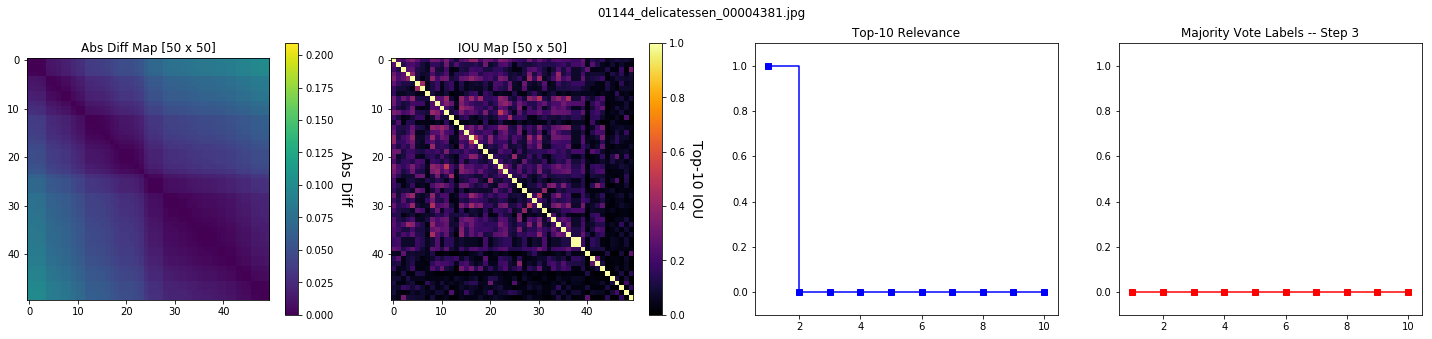

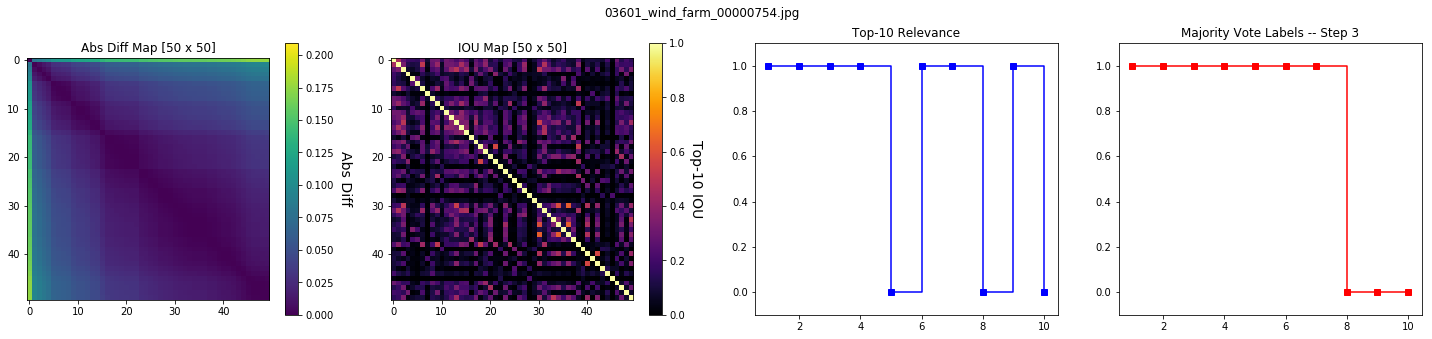

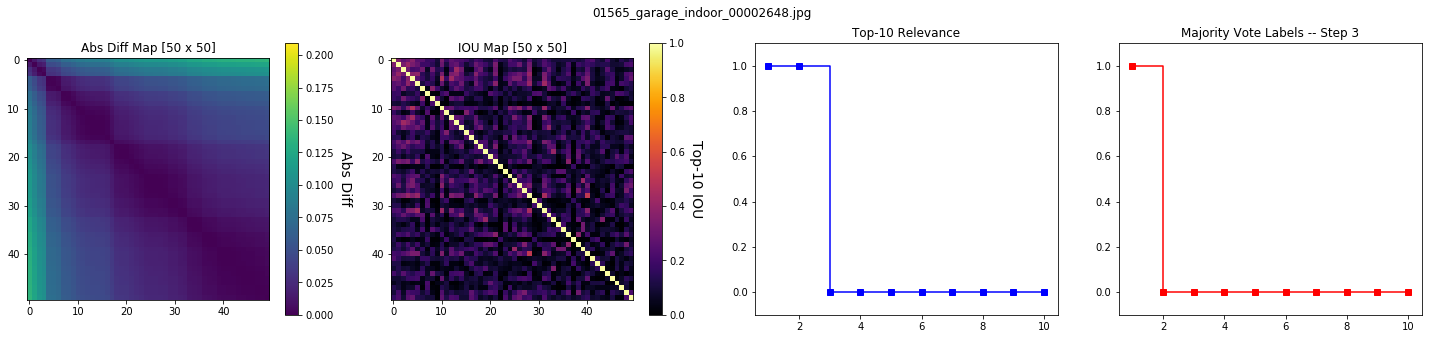

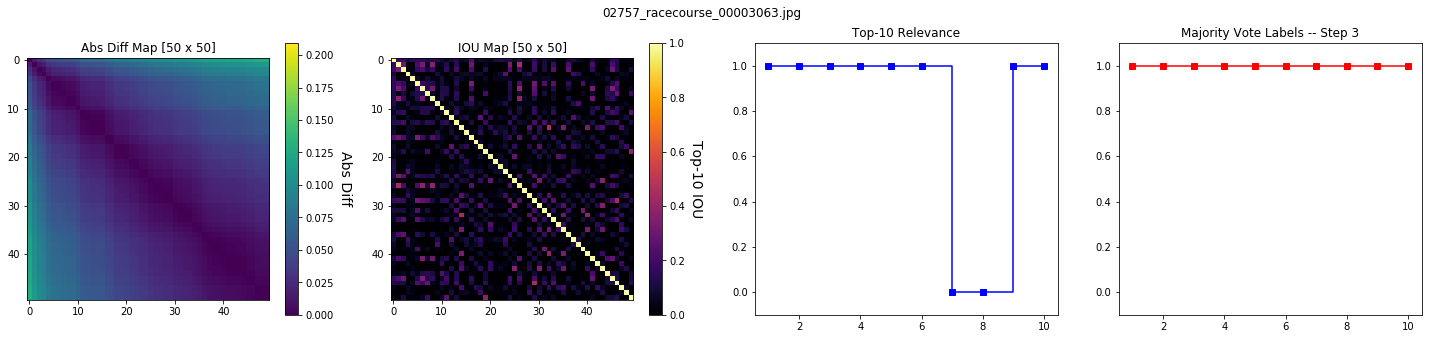

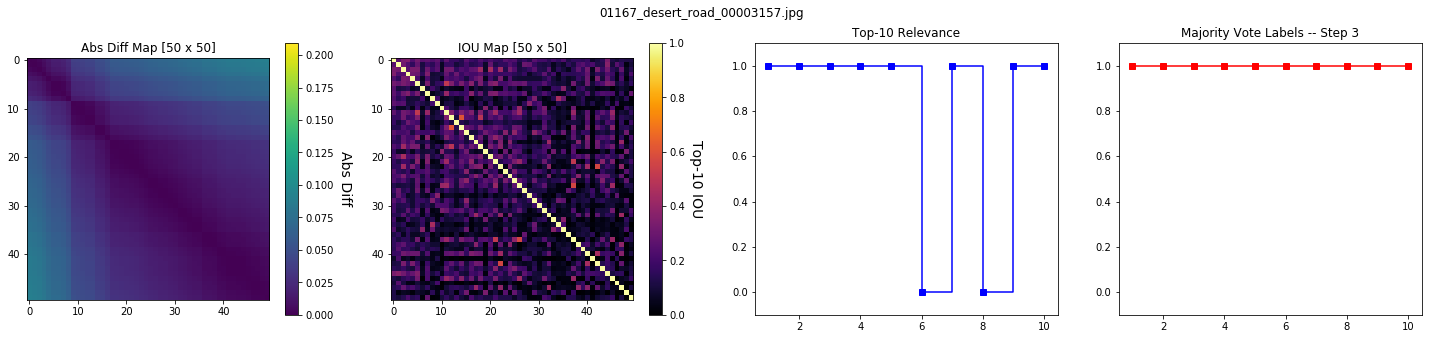

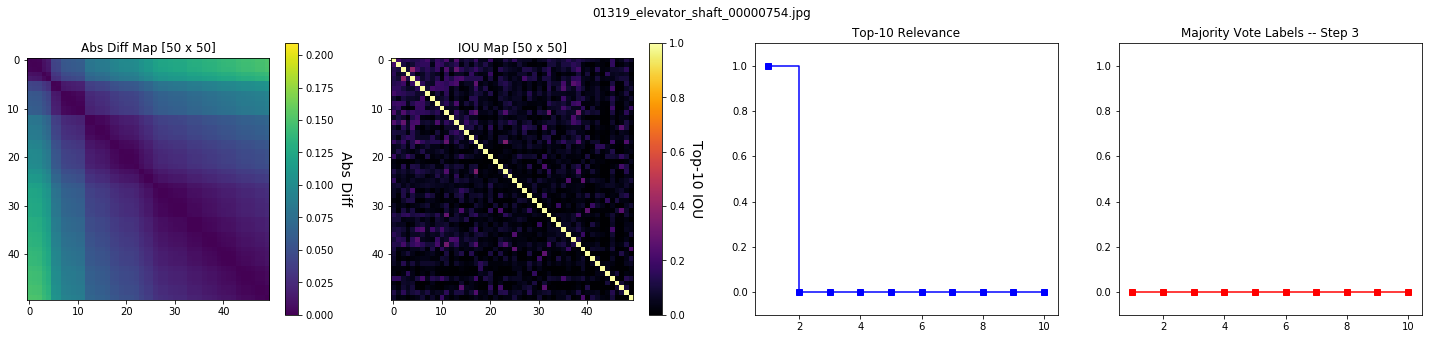

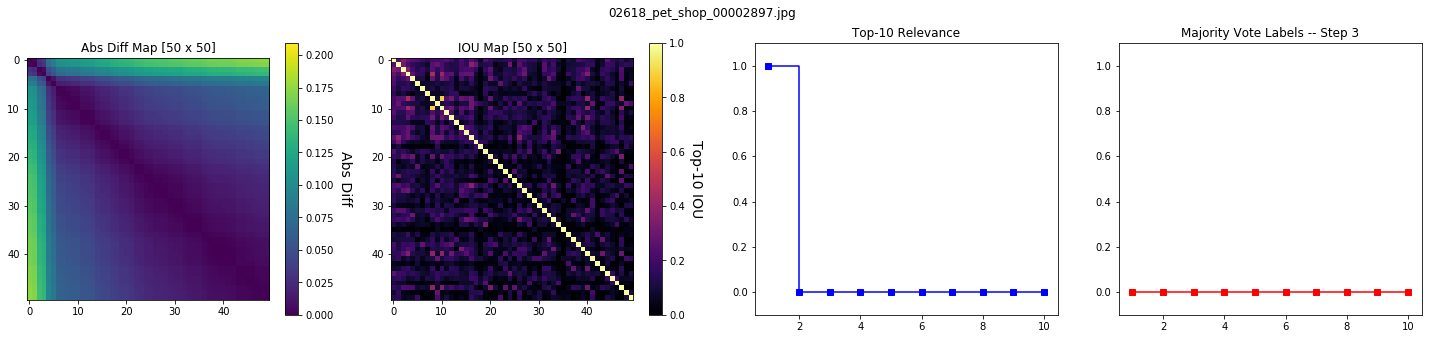

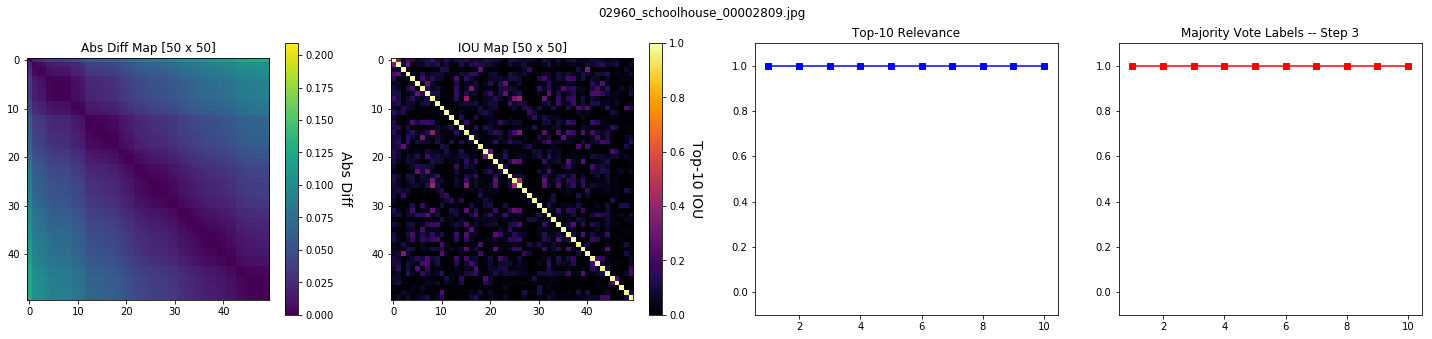

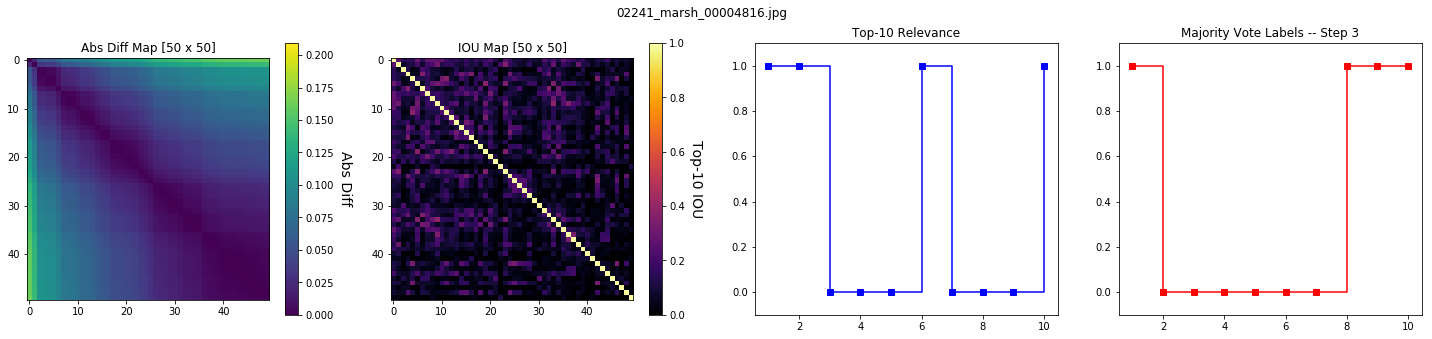

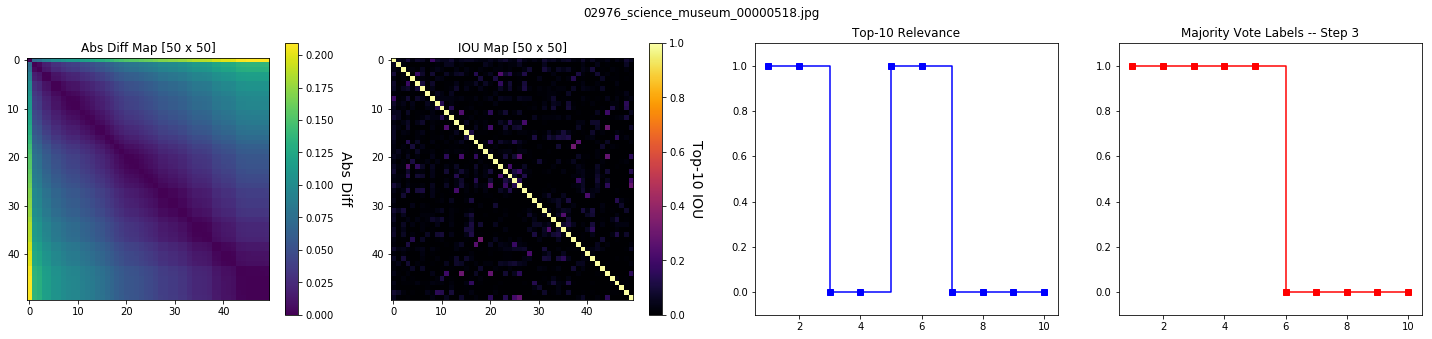

In [12]:
m = 50

diff_maps = []
iou_maps = []
label_array = []
titles = []

for i in iidx_list:
    rkfpath = rkflist[i]
    titles.append(getbasename(rkfpath))
    rank = read_rank(rkfpath)
    rank_s = minmaxscaler.fit_transform(rank['score'].reshape(-1, 1)).reshape(-1)
    rank_c = 1.0 - rank_s
    
    ###
    diff_maps.append(np.abs(rank_c[1:m+1].reshape(-1, 1) - rank_c[1:m+1].reshape(1, -1)))
    ###
    
    ###
    top_idx = np.searchsorted(namelist, rank['name'][0:m])
    top_idx_array = collm[top_idx, 0:m]

    iou_map = np.zeros((top_idx_array.shape[0], top_idx_array.shape[0]), dtype=np.float64)
    for j, row in enumerate(top_idx_array):
        iou_map[j] = np.apply_along_axis(iou, axis=1, arr=top_idx_array, **dict(b=row))
        
    iou_maps.append(iou_map)
    ###
    
    ###
    label_array.append(labels[i, 0:k+vs])
    
diff_maps = np.stack(diff_maps)
iou_maps = np.stack(iou_maps)
label_array = np.vstack(label_array)

min_diff = np.min(diff_maps)
max_diff = np.max(diff_maps)
    
for i in range(c):
    
    diff_map = diff_maps[i]
    iou_map = iou_maps[i]
    l = label_array[i]
    mv = maj_vote_labels(l, k, vs)
    
    x = np.arange(1, k+1, 1)
    ###
    
    fig, ax = plt.subplots(1, 4)
    fig.set_size_inches(25, 5)

    im = ax[0].imshow(diff_map, plt.get_cmap('viridis'), vmin=min_diff, vmax=max_diff)
    cbar = fig.colorbar(im, ax=ax[0])
    cbar.ax.set_ylabel('Abs Diff', rotation=-90, va="bottom", fontdict=dict(fontsize=14))
    ax[0].set_title('Abs Diff Map [{0:d} x {0:d}]'.format(m))

    im = ax[1].imshow(iou_map, plt.get_cmap('inferno'), vmin=0.0, vmax=1.0)
    cbar = fig.colorbar(im, ax=ax[1])
    cbar.ax.set_ylabel('Top-{0:d} IOU'.format(k), rotation=-90, va="bottom", fontdict=dict(fontsize=14))
    ax[1].set_title('IOU Map [{0:d} x {0:d}]'.format(m))
    
    ax[2].step(x, l[0:k], color='blue', marker='s', where='post', label='post')
    ax[2].set_title('Top-{0:d} Relevance'.format(k))
    ax[2].set_ylim(bottom=-0.1, top=1.1)
    
    ax[3].step(x[0:k], mv, color='red', marker='s', where='post', label='post')
    ax[3].set_title('Majority Vote Labels -- Step {0:d}'.format(vs))
    ax[3].set_ylim(bottom=-0.1, top=1.1)
    
    fig.suptitle(titles[i])

### 100 x 100 Patches

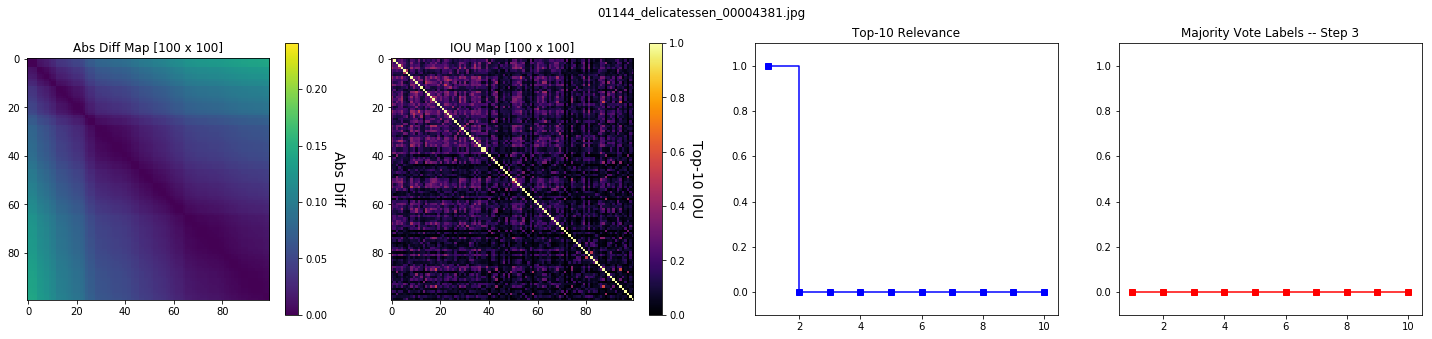

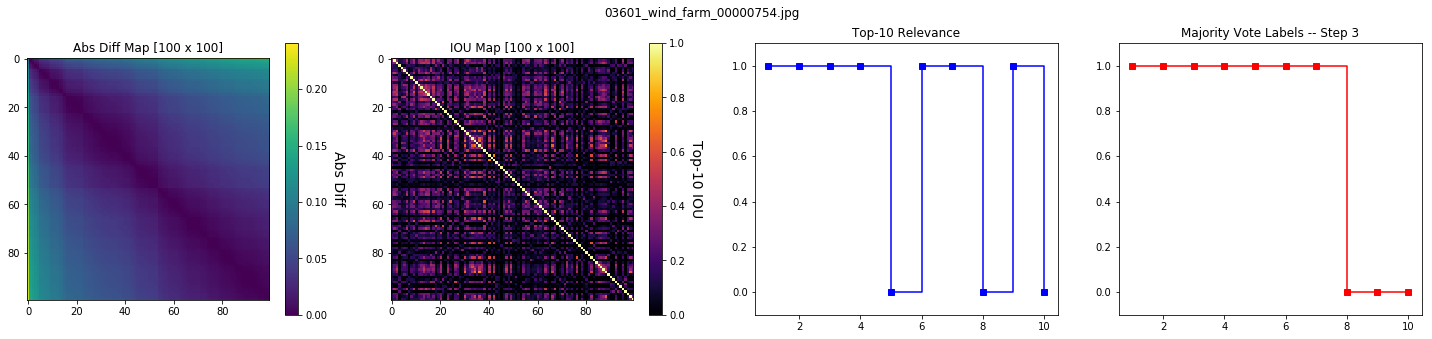

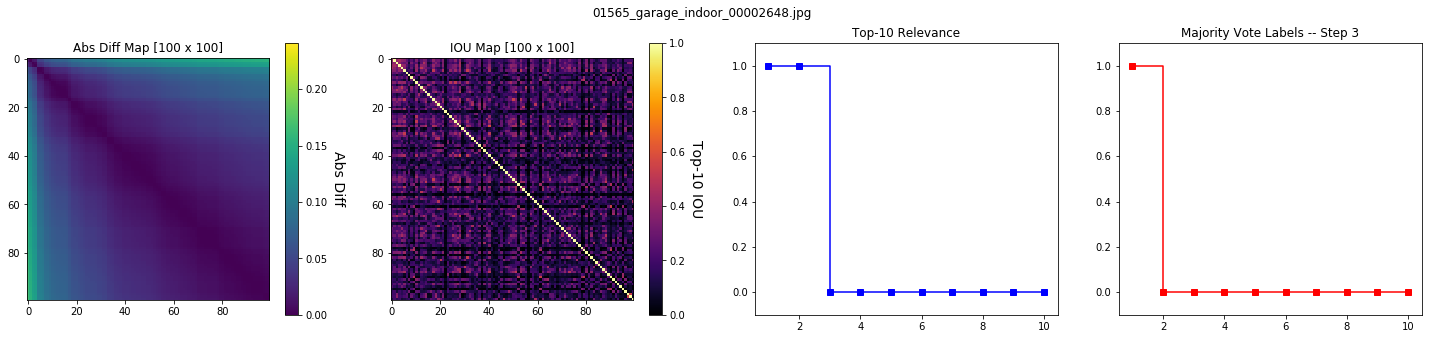

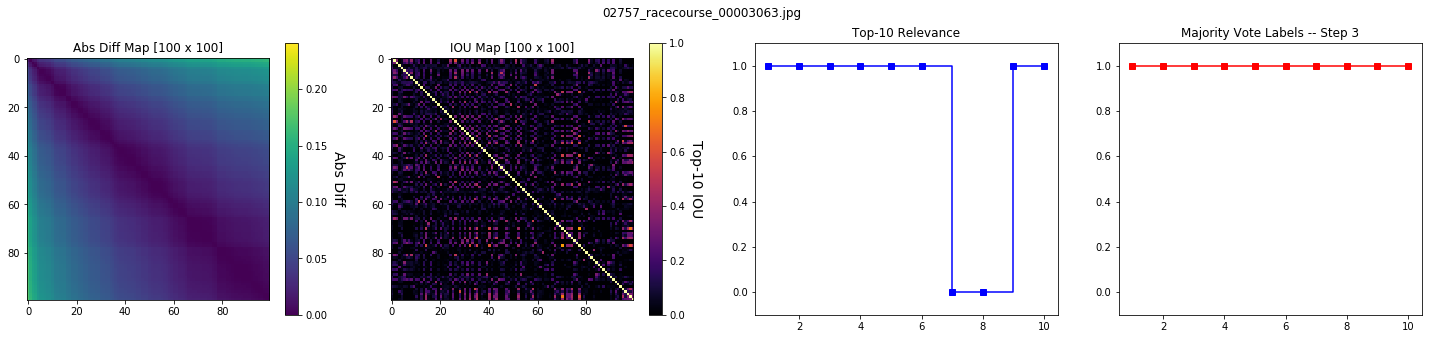

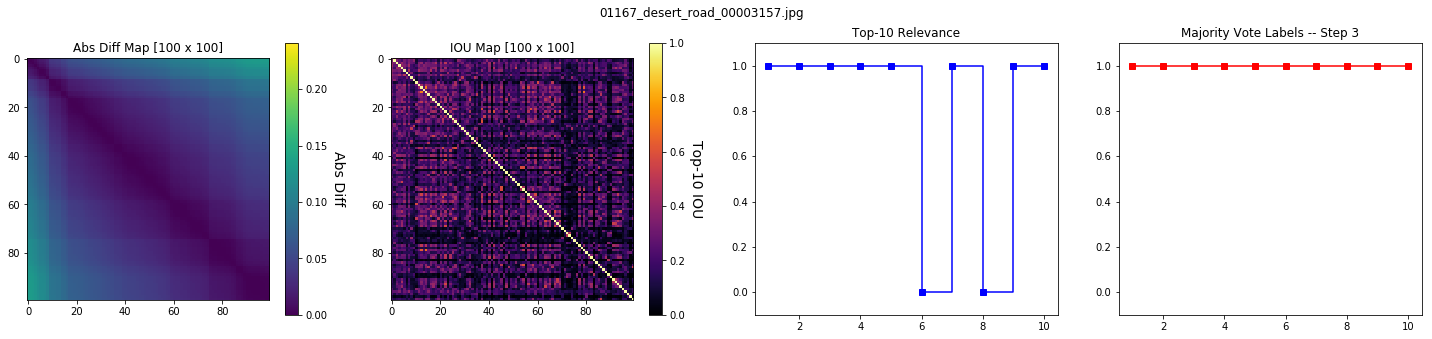

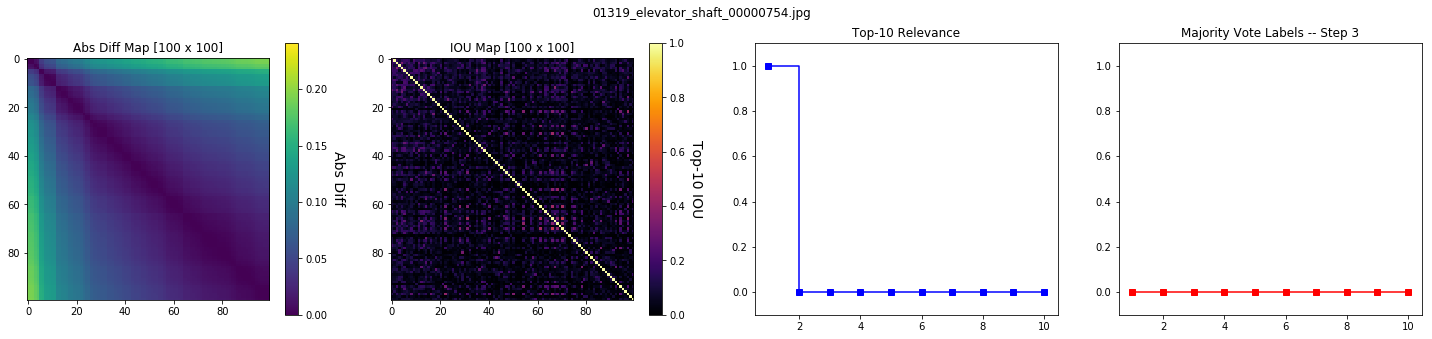

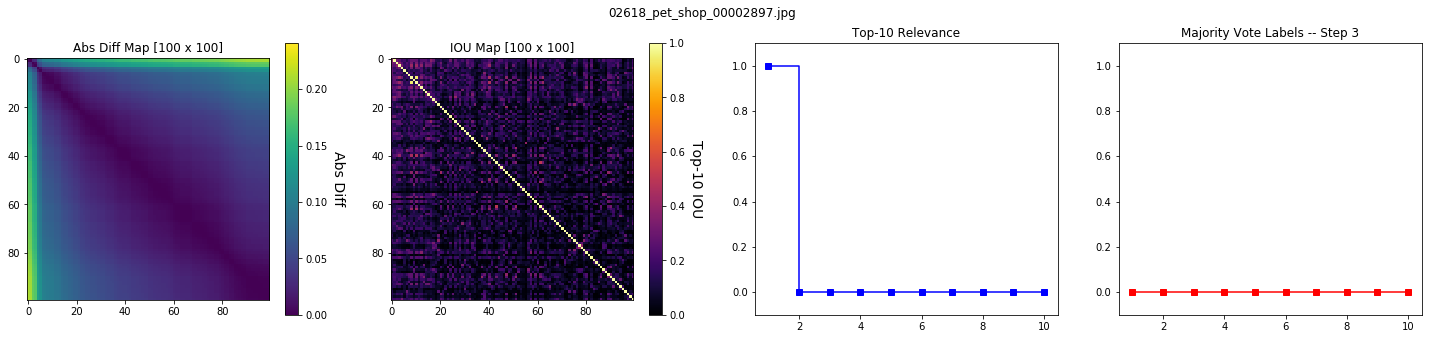

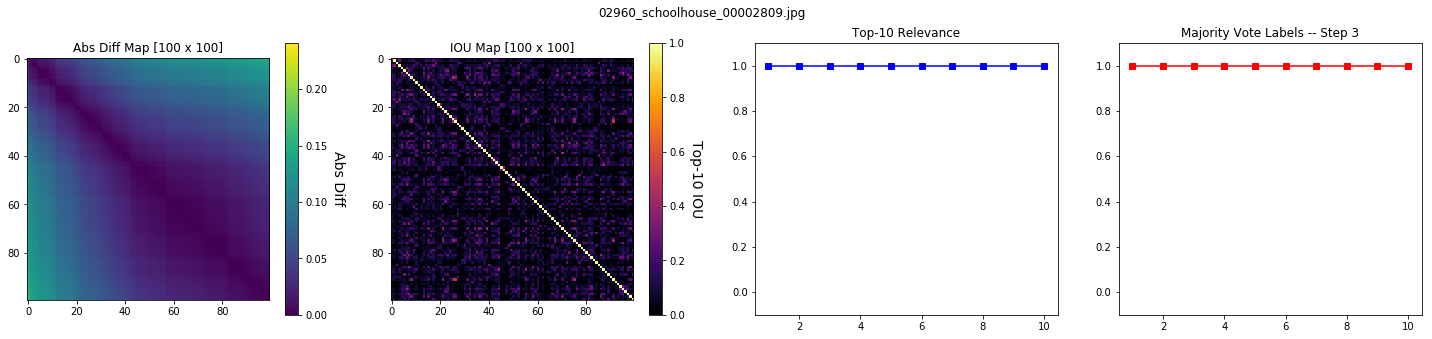

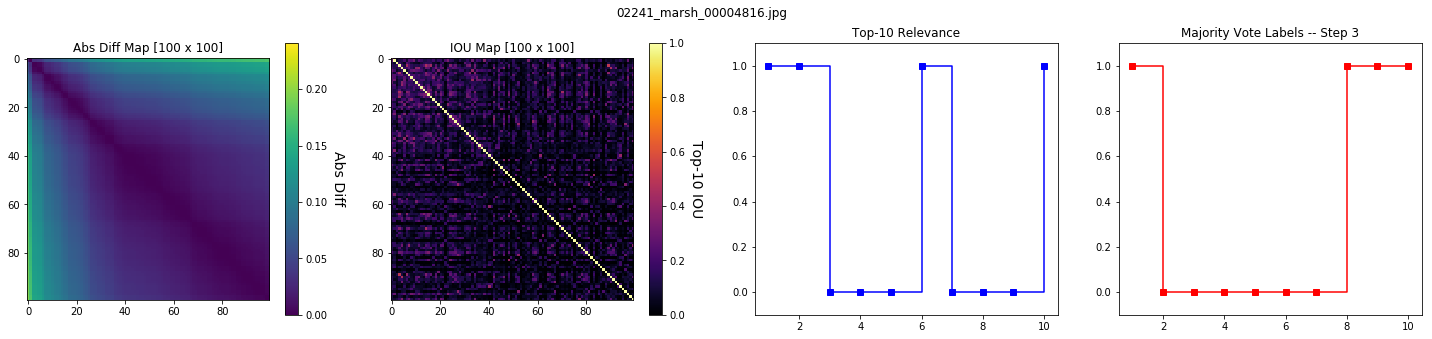

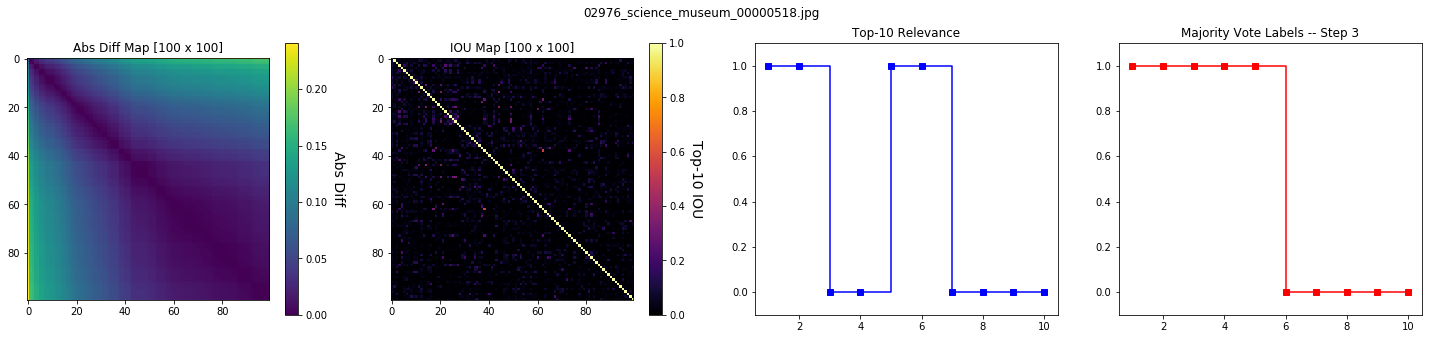

In [13]:
m = 100

diff_maps = []
iou_maps = []
label_array = []
titles = []

for i in iidx_list:
    rkfpath = rkflist[i]
    titles.append(getbasename(rkfpath))
    rank = read_rank(rkfpath)
    rank_s = minmaxscaler.fit_transform(rank['score'].reshape(-1, 1)).reshape(-1)
    rank_c = 1.0 - rank_s
    
    ###
    diff_maps.append(np.abs(rank_c[1:m+1].reshape(-1, 1) - rank_c[1:m+1].reshape(1, -1)))
    ###
    
    ###
    top_idx = np.searchsorted(namelist, rank['name'][0:m])
    top_idx_array = collm[top_idx, 0:m]

    iou_map = np.zeros((top_idx_array.shape[0], top_idx_array.shape[0]), dtype=np.float64)
    for j, row in enumerate(top_idx_array):
        iou_map[j] = np.apply_along_axis(iou, axis=1, arr=top_idx_array, **dict(b=row))
        
    iou_maps.append(iou_map)
    ###
    
    ###
    label_array.append(labels[i, 0:k+vs])
    
diff_maps = np.stack(diff_maps)
iou_maps = np.stack(iou_maps)
label_array = np.vstack(label_array)

min_diff = np.min(diff_maps)
max_diff = np.max(diff_maps)
    
for i in range(c):
    
    diff_map = diff_maps[i]
    iou_map = iou_maps[i]
    l = label_array[i]
    mv = maj_vote_labels(l, k, vs)
    
    x = np.arange(1, k+1, 1)
    ###
    
    fig, ax = plt.subplots(1, 4)
    fig.set_size_inches(25, 5)

    im = ax[0].imshow(diff_map, plt.get_cmap('viridis'), vmin=min_diff, vmax=max_diff)
    cbar = fig.colorbar(im, ax=ax[0])
    cbar.ax.set_ylabel('Abs Diff', rotation=-90, va="bottom", fontdict=dict(fontsize=14))
    ax[0].set_title('Abs Diff Map [{0:d} x {0:d}]'.format(m))

    im = ax[1].imshow(iou_map, plt.get_cmap('inferno'), vmin=0.0, vmax=1.0)
    cbar = fig.colorbar(im, ax=ax[1])
    cbar.ax.set_ylabel('Top-{0:d} IOU'.format(k), rotation=-90, va="bottom", fontdict=dict(fontsize=14))
    ax[1].set_title('IOU Map [{0:d} x {0:d}]'.format(m))
    
    ax[2].step(x, l[0:k], color='blue', marker='s', where='post', label='post')
    ax[2].set_title('Top-{0:d} Relevance'.format(k))
    ax[2].set_ylim(bottom=-0.1, top=1.1)
    
    ax[3].step(x[0:k], mv, color='red', marker='s', where='post', label='post')
    ax[3].set_title('Majority Vote Labels -- Step {0:d}'.format(vs))
    ax[3].set_ylim(bottom=-0.1, top=1.1)
    
    fig.suptitle(titles[i])